In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

# distgen Generator - particle generation

In [2]:
from distgen import Generator
from astra import Astra
from pmd_beamphysics import ParticleGroup
from pmd_beamphysics.plot import marginal_plot
import os

In [3]:
# Get an input file
distgen_in = 'templates/dcgun/distgen.yaml'

In [4]:
# Make object, and show its input (calls __repr__)
D = Generator(input=distgen_in, verbose=True)

# Change something
D.input['n_particle'] = 10000

D

<disgten.Generator with input: 
n_particle: 10000
r_dist:
  max_r:
    units: mm
    value: 0.5
  type: radial_uniform
random_type: hammersley
start:
  MTE:
    units: meV
    value: 250
  type: cathode
t_dist:
  avg_t:
    units: ps
    value: 0
  n_sigma_cutoff: 3
  sigma_t:
    units: ps
    value: 8.5
  type: gaussian
total_charge:
  units: pC
  value: 100

>

In [5]:
# Run, and get particles
D.run()
P = D.particles
P

Distribution format: None
Output file: None

Creating beam distribution....
   Beam starting from: cathode
   Total charge: 100 pC.
   Number of macroparticles: 10000.
   Assuming cylindrical symmetry...
   r distribution: radial uniform
      min_r = 0 mm, max_r = 0.5 mm
   theta distribution: uniform theta
      min_theta = 0 rad, max_theta = 6.28319 rad
   t distribution: Gaussian
      avg_t = 0 ps, sigma_t = 8.500 ps
      Left n_sigma_cutoff = 3, Right n_sigma_cutoff = -3
   px distribution: Gaussian
      avg_px = 0 eV/c, sigma_px = 357.421 eV/c
   py distribution: Gaussian
      avg_py = 0 eV/c, sigma_py = 357.421 eV/c
   pz distribution: Gaussian
      avg_pz = 0 eV/c, sigma_pz = 357.421 eV/c
   Shifting avg_x = -7.47173E-05 mm -> 0 mm
   Scaling sigma_x = 0.249929 mm -> 0.25 mm
   Shifting avg_y = -1.38656E-05 mm -> 0 mm
   Scaling sigma_y = 0.250006 mm -> 0.25 mm
   Shifting avg_px = -0.330541 eV/c -> 0 eV/c
   Scaling sigma_px = 357.326 eV/c -> 357.421 eV/c
   Shifting avg_

<ParticleGroup with 10000 particles at 0x15bbd5c10>

In [6]:
# Check stats from ParticleGroup's calculation
for x in ['x', 'y', 't', 'px', 'py', 'pz']:
    k = 'sigma_'+x
    print(k, ':', P[k], P.units(k))

sigma_x : 0.00025 m
sigma_y : 0.00025000000000000006 m
sigma_t : 8.385916336743923e-12 s
sigma_px : 357.42095279935677 eV/c
sigma_py : 357.4209527993567 eV/c
sigma_pz : 215.24591951491522 eV/c


In [7]:
for x in ['x', 'y', 't', 'px', 'py', 'pz']:
    k1 = 'min_'+x
    k2 = 'max_'+x
    print(k1, ':', P[k1], P.units(k1))
    print(k2, ':', P[k2], P.units(k2))

min_x : -0.0004988339143630186 m
max_x : 0.0004995381906563349 m
min_y : -0.0004985691789594443 m
max_y : 0.000499349101483808 m
min_t : -2.5403549006681152e-11 s
max_t : 2.523953670341706e-11 s
min_px : -1369.0542015583897 eV/c
max_px : 1269.8138040611411 eV/c
min_py : -1375.1716870493833 eV/c
max_py : 1249.5568036296586 eV/c
min_pz : 0.0270892671432289 eV/c
max_pz : 1363.8558255685525 eV/c


# Run Astra with Distgen

In [8]:
# Input template file 
ASTRA_IN = 'templates/dcgun/astra.in'

In [9]:
# Make an Astra object
A = Astra(input_file=ASTRA_IN, initial_particles=P)

# Change some inputs
A.input['newrun']['zemit']  = 1000
A.input['newrun']['zphase'] = 20
A.input['newrun']['phases'] = True
A.input['newrun']['zstop']  = 1

# Special flag
A.verbose = False

In [10]:
A.run()

# Plot

In [11]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = (8,5)

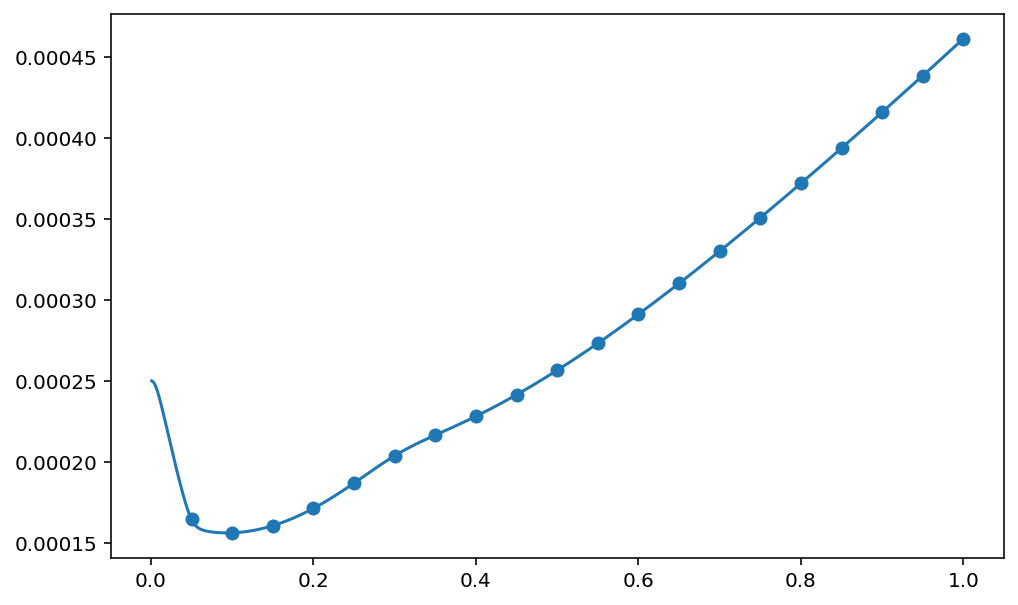

In [12]:
plt.plot(A.stat('mean_z'), A.stat('sigma_x'))
plt.scatter(A.particle_stat('mean_z'), A.particle_stat('sigma_x'))

# Compare with AstraGenerator

In [13]:
from astra import AstraGenerator

In [14]:
GENERATOR_IN = 'templates/dcgun/generator.in'
# Make generator object
G = AstraGenerator(input_file=GENERATOR_IN)
G.input['ipart'] = 10000
G.run()
P2 = G.output['particles']

In [15]:
A2 = Astra(input_file=ASTRA_IN, initial_particles=P2)

# Change some inputs
A2.input['newrun']['zemit']  = 1000
A2.input['newrun']['zphase'] = 20
A2.input['newrun']['phases'] = True
A2.input['newrun']['zstop']  = 1
A2.run()

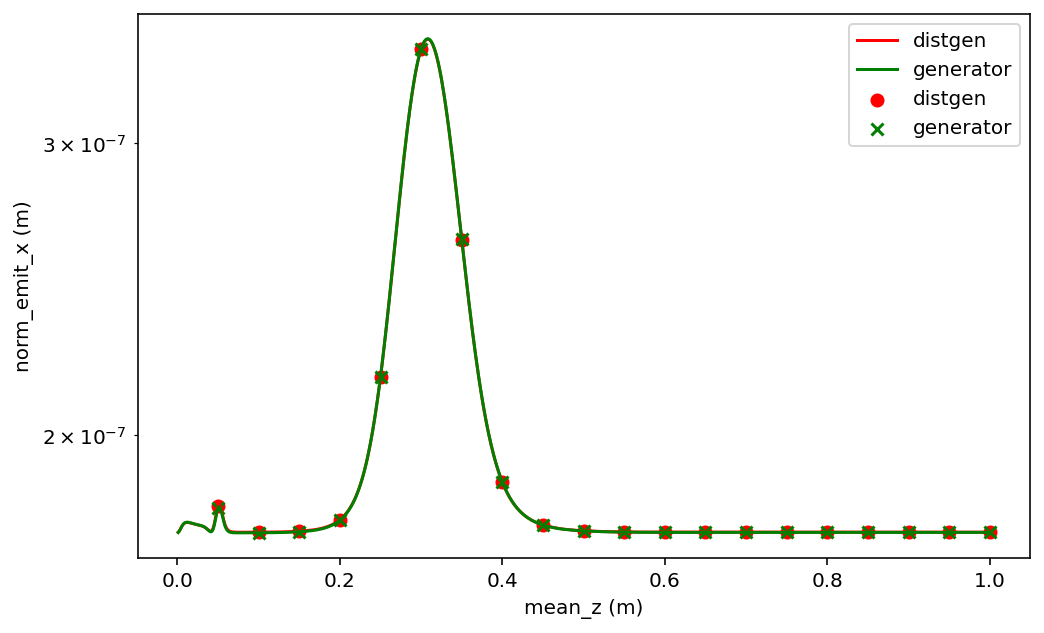

In [21]:
k1 = 'mean_z'
k2 = 'norm_emit_x'

u1 = A.units(k1)
u2 = A.units(k2)
plt.xlabel(k1+f' ({u1})')
plt.ylabel(k2+f' ({u2})')
plt.yscale('log')
plt.plot(A.stat(k1), A.stat(k2), color='red', label='distgen')
plt.plot(A2.stat(k1), A2.stat(k2), color='green', label='generator')
plt.scatter(A.particle_stat(k1), A.particle_stat(k2), color='red', label='distgen'),
plt.scatter(A2.particle_stat(k1), A2.particle_stat(k2), color='green', marker='x', label='generator')
plt.legend()

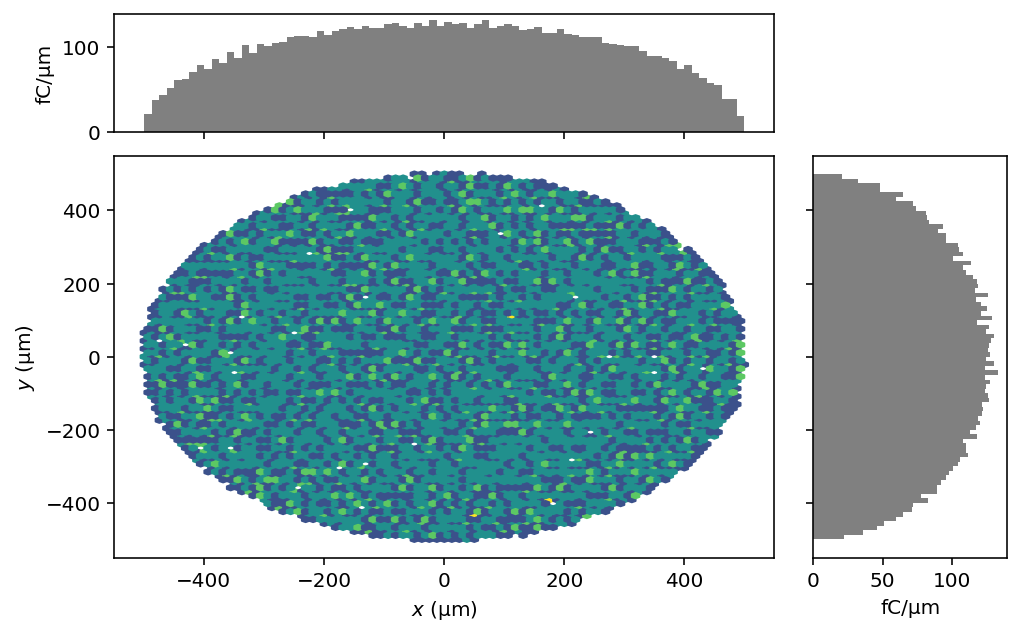

In [17]:
# distgen
A.initial_particles.plot('x', 'y', bins=80)

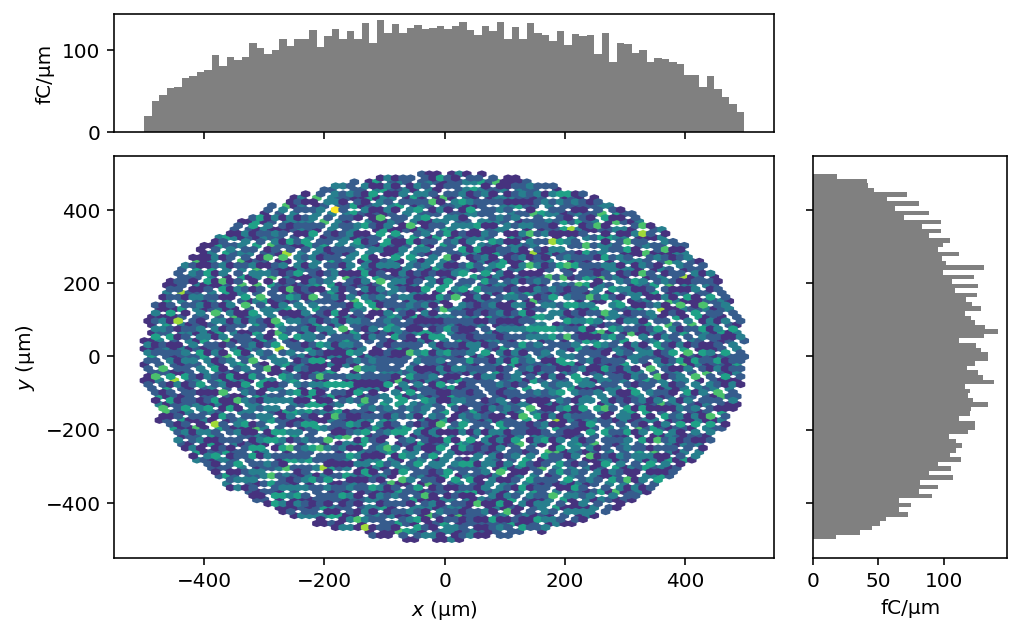

In [18]:
# Generator
A2.initial_particles.plot('x', 'y', bins=80)

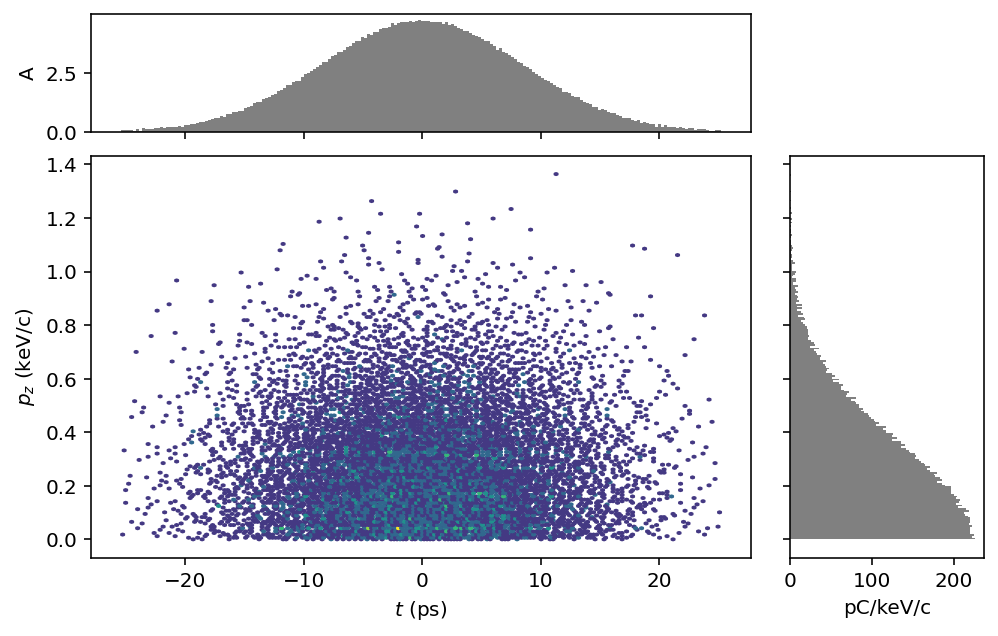

In [19]:
# Distgen initial particles in time, z-momentum
A.initial_particles.plot( 't', 'pz', bins=200)

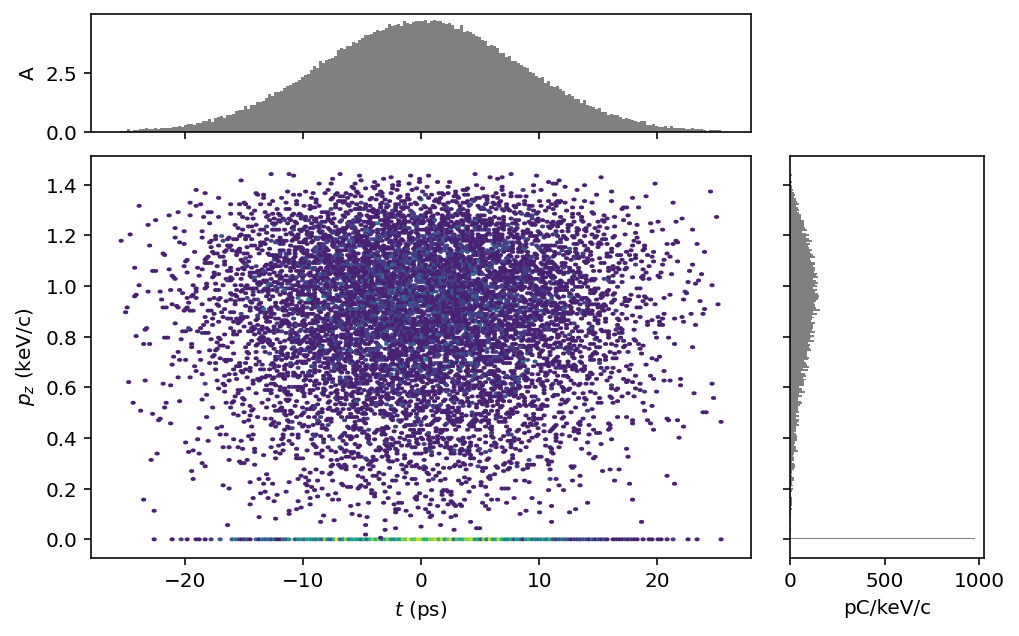

In [20]:
# Generator initial particles in time, z-momentum
# The spike at pz=0 is a known limitation
A2.initial_particles.plot('t', 'pz', bins=200)